# Experiments

In [2]:
# Import packages
import random
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import FuncFormatter
import numpy as np
import copy

from Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D
from Bias import BIASme, bias_rotate_2D
from Transformations import remove_outliers_lof, trafo_ica
from DensityEstimators import DE_histogram, DE_kde
from IMITATE import IMITATE
import warnings
warnings.filterwarnings('ignore')

## Different rotation biases
How does the rotation change the quality? We evaluate the remaining accuracy gap between a classifier trained on the original dataset and that on the biased dataset

In [3]:
def run_experiment(num_bins, alpha, biasedClass, repeat=10):
    #DE = DE_histogram
    DE = lambda b: DE_kde(num_bins=b, kernel='gau')
    bias_gen = lambda a, b: bias_rotate_2D(training=a, labels=b, alpha=alpha*np.pi, biasedClass=biasedClass)
    data_gen = generateData_twoPills_noNoise_2D
    bh = IMITATE([10], bias_gen, data_gen, repeat=1, DE=DE, trafo=trafo_ica)
    
    # run 10 times, pick the result with the highest confidence
    max_conf = 0
    for bins in num_bins:
        for i in range(repeat):
            bh.reset()
            label_conf = bh.fill_up(num_bins=bins, iterations=2, fill_up_plots=False, point_plots=False, RO=True)
            #print("run", i, ", conf", label_conf)
            if max(label_conf) >= max_conf:
                max_conf = max(label_conf)
                best_bh = copy.deepcopy(bh)
    return best_bh, max_conf

In [4]:
def evaluate(bh):
    acc_orig = bh.D.acc_unbiased
    acc_init = bh.D.acc_init
    acc_final = bh.D.accuracyBiased(bh.added_points, bh.added_labels)
    return (acc_orig - acc_init), (acc_orig - acc_final)

In [5]:
def run_and_eval(alphas, runs=10):
    acc_init_0 = np.zeros((len(alphas), runs))
    acc_init_1 = np.zeros((len(alphas), runs))
    acc_final_0 = np.zeros((len(alphas), runs))
    acc_final_1 = np.zeros((len(alphas), runs))
    conf_0 = np.zeros((len(alphas), runs))
    conf_1 = np.zeros((len(alphas), runs))
    hist_bins = list(range(16,30,3))
    
    for r in range(runs):
        for i in range(len(alphas)):
            alpha = alphas[i]
            bh, conf_0[i][r] = run_experiment(hist_bins, alpha, 0, repeat=2)
            acc_init_0[i][r], acc_final_0[i][r] = evaluate(bh)
            bh, conf_1[i][r] = run_experiment(hist_bins, alpha, 1, repeat=2)
            acc_init_1[i][r], acc_final_1[i][r] = evaluate(bh)

    return acc_init_0, acc_init_1, acc_final_0, acc_final_1, conf_0, conf_1, alphas

In [6]:
def plot_results(results):
    acc_init_0 = results[0]
    acc_init_1 = results[1]
    acc_final_0 = results[2]
    acc_final_1 = results[3]
    conf_0 = results[4]
    conf_1 = results[5]
    alphas = results[6]
       
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,3))
    plt.subplots_adjust(wspace = 0.4)
    x = alphas
    
    color1 = plt.cm.viridis(0)
    color2 = plt.cm.viridis(0.5)
    color3 = plt.cm.viridis(.9)
    m = ['o', '^', '*', 'x']
    
    # bias class 0
    #conf0 = ax[0].twinx()
    ax[0].set_xticks(range(len(x)))
    ax[0].set_xticklabels(x)
    ax[0].set_xlabel("Bias Rotation Angle (*PI)")
    ax[0].set_ylabel("Accuracy: Gap to Original")
    #conf0.set_ylabel("Confidence")
    ax[0].title.set_text('Bias Class purple')
    
    acc_line, = ax[0].plot(np.average(acc_init_0,axis=1), color=color1, marker=m[0], linestyle='--', label="Initial Accuracy Gap")
    acc_line2, = ax[0].plot(np.average(acc_final_0,axis=1), color=color1,marker=m[1], label="Final Accuracy Gap")
    #conf0.plot(np.average(conf_0,axis=1), color=color2, marker=m[2], label="Confidence")
    
    ax[0].yaxis.label.set_color(acc_line.get_color())
    #conf0.yaxis.label.set_color(color2)
    
    # bias class 1
    #conf1 = ax[1].twinx()
    ax[1].set_xticks(range(len(x)))
    ax[1].set_xticklabels(x)
    ax[1].set_xlabel("Bias Rotation Angle (*PI)")
    ax[1].set_ylabel("Accuracy: Gap to Original")
    #conf1.set_ylabel("Confidence")
    ax[1].title.set_text('Bias Class turquoise')
    
    acc_line = ax[1].plot(np.average(acc_init_1,axis=1), color=color1, marker=m[0], linestyle='--',label="Initial Acc Gap")
    acc_line2 = ax[1].plot(np.average(acc_final_1,axis=1), color=color1,marker=m[1], label="Final Acc Gap")
    #conf_line = conf1.plot(np.average(conf_1,axis=1), color=color2, marker=m[2], label="Confidence")
    
    ax[1].yaxis.label.set_color(acc_line[0].get_color())
    #conf1.yaxis.label.set_color(conf_line[0].get_color())
    
    lns = acc_line+acc_line2#+conf_line
    labs = [l.get_label() for l in lns]
    ax[0].legend(lns, labs, loc='best')
    fig.savefig('Results/Exp_synth_angles.pdf', format='pdf', dpi=1200, bbox_inches='tight')
    plt.show()

In [7]:
results = run_and_eval([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75], runs=10)

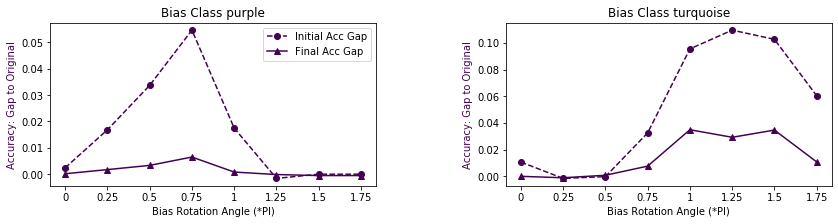

In [8]:
plot_results(results)

In [2]:
interesting_cases = [[0.5,0], [0.75,0], [1,1], [1.25,1], [1.5,1], [1.75,1]]

## Different probabilities that points remain in the biased area
How does the amount of remaining points in the biased area affect the result?

In [66]:
def run_experiment_prob(num_bins, alpha, biasedClass, prob, repeat=5):
    #DE = DE_histogram
    DE = lambda b: DE_kde(num_bins=b, kernel='gau')
    bias_gen = lambda a, b: bias_rotate_2D(training=a, labels=b, alpha=alpha*np.pi, biasedClass=biasedClass, prob=prob)
    data_gen = generateData_twoPills_noNoise_2D
    bh = IMITATE([10], bias_gen, data_gen, repeat=1, DE=DE, trafo=trafo_ica)
    
    # run 10 times, pick the result with the highest confidence
    max_conf = best_bins = 0
    for bins in num_bins:
        for i in range(repeat): # due to the randomness in ICA
            bh.reset()
            # iterations in fill_up due to the randomness of generating points
            label_conf = bh.fill_up(num_bins=bins, iterations=5, fill_up_plots=False, point_plots=False, RO=True)
            #print("bins", bins, "run", i, ", conf", label_conf)
            if max(label_conf) >= max_conf:
                max_conf = max(label_conf)
                best_bh = copy.deepcopy(bh)
                best_bins = bins
    #print("best bins =", best_bins)
    #best_bh.plot_result()
    return best_bh

In [3]:
# return the improvement in accuracy: (acc_final - acc_init) / (acc_orig - acc_init)
def evaluate_prob(bh):
    acc_orig = bh.D.acc_unbiased
    acc_init = bh.D.acc_init
    acc_final = bh.D.accuracyBiased(bh.added_points, bh.added_labels)
    return (acc_orig - acc_init), (acc_orig - acc_final)

In [68]:
def run_and_eval_prob(alphas_classes, probs, runs=10):
    hist_bins = list(range(20,30,3))
    print("probs:", probs)
    acc_i = np.zeros((len(alphas_classes), len(probs), runs))
    acc_f = np.zeros((len(alphas_classes), len(probs), runs))
    
    for ac_ in range(len(alphas_classes)):
        ac = alphas_classes[ac_]
        for p_ in range(len(probs)):
            p = probs[p_]
            for r in range(runs): # due to the randomness of generating datasets
                acc_i[ac_][p_][r], acc_f[ac_][p_][r] = evaluate_prob(run_experiment_prob(hist_bins, ac[0], ac[1], p, repeat=10))
            print("ac =", ac, "p =", p, "acc_i =", np.average(acc_i[ac_][p_]), "acc_f =", np.average(acc_f[ac_][p_]))
    return acc_i, acc_f

In [57]:
res_prob = run_and_eval_prob(interesting_cases, [0,0.05,0.1,0.2,0.5], runs=10)

probs: [0, 0.05, 0.1, 0.2, 0.5]
ac = [0.5, 0] p = 0 acc_i = 0.06406666666666666 acc_f = 0.017766666666666653
ac = [0.5, 0] p = 0.05 acc_i = 0.03539999999999997 acc_f = 0.002266666666666661
ac = [0.5, 0] p = 0.1 acc_i = 0.02693333333333333 acc_f = 0.0014666666666666606
ac = [0.5, 0] p = 0.2 acc_i = 0.019299999999999963 acc_f = 0.003400000000000003
ac = [0.5, 0] p = 0.5 acc_i = 0.004266666666666674 acc_f = 0.002000000000000013
ac = [0.75, 0] p = 0 acc_i = 0.09236666666666668 acc_f = 0.014633333333333342
ac = [0.75, 0] p = 0.05 acc_i = 0.05673333333333332 acc_f = 0.007099999999999984
ac = [0.75, 0] p = 0.1 acc_i = 0.045533333333333335 acc_f = 0.007266666666666666
ac = [0.75, 0] p = 0.2 acc_i = 0.01799999999999998 acc_f = 0.0011666666666666826
ac = [0.75, 0] p = 0.5 acc_i = 0.0038666666666666515 acc_f = 0.0002666666666666484
ac = [1, 1] p = 0 acc_i = 0.1146 acc_f = 0.06760000000000002
ac = [1, 1] p = 0.05 acc_i = 0.09846666666666666 acc_f = 0.029299999999999982
ac = [1, 1] p = 0.1 acc_i = 

In [49]:
def plot_results_prob(results):
       
    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(14,3))
    plt.subplots_adjust(wspace = 0.4)
    b = ["p, 0.5", "p, 0.75", 't, 1', 't, 1.25', 't, 1.5', 't, 1.75']
    x = [0, 0.05, 0.1, 0.2, 0.5]
    
    color1 = plt.cm.viridis(0)
    m = ['o', '^', '*', 'x']
    
    # bias class 0
    #conf0 = ax[0].twinx()
    for i in range(6):
        ax[i].set_xticks(range(len(x)))
        ax[i].set_xticklabels(x)
        ax[i].set_xlabel("p")
        ax[i].get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y*100), ',')))
        if(i == 0):
            ax[i].set_ylabel("Accuracy (in %): Gap to Original")
        ax[i].title.set_text(b[i])

        i_line, = ax[i].plot(np.average(results[0][i], axis=1), color=color1, marker=m[0], linestyle='--', label="Initial")
        f_line, = ax[i].plot(np.average(results[1][i], axis=1), color=color1,marker=m[1], label="Final")
        #i_line, = ax[i].plot(results[0][i], color=color1, marker=m[0], linestyle='--', label="Initial")
        #f_line, = ax[i].plot(results[1][i], color=color1,marker=m[1], label="Final")
    
        ax[i].yaxis.label.set_color(i_line.get_color())
    
    lg = ax[5].legend(loc='upper right') #bbox_to_anchor=(1.05, 1.0), loc='upper left'
    fig.savefig('Results/Exp_synth_prob.pdf', format='pdf', dpi=1200, bbox_inches='tight')#, bbox_extra_artists=(lg,))
    plt.show()

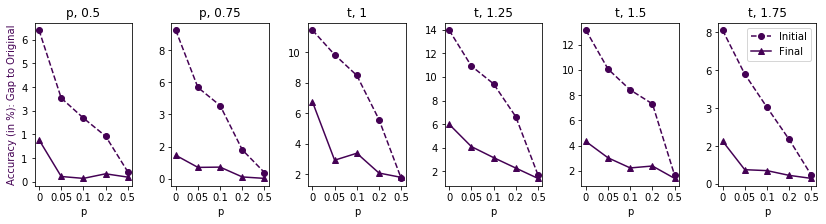

In [50]:
plot_results_prob(res_prob)

## Noise in the dataset
How does the amount of noise in the dataset affect the result?

In [4]:
def run_experiment_noise(num_bins, alpha, biasedClass, noise, repeat=10):
    #DE = DE_histogram
    DE = lambda b: DE_kde(num_bins=b, kernel='gau')
    bias_gen = lambda a, b: bias_rotate_2D(training=a, labels=b, alpha=alpha*np.pi, biasedClass=biasedClass)
    data_gen = lambda a: generateData_twoPills_2D(a, noise=noise)
    bh = IMITATE([10], bias_gen, data_gen, repeat=1, DE=DE, trafo=trafo_ica)
    
    # run 10 times, pick the result with the highest confidence
    max_conf = 0
    for bins in num_bins:
        for i in range(repeat):
            bh.reset()
            label_conf = bh.fill_up(num_bins=bins, iterations=5, fill_up_plots=False, point_plots=False, RO=True)
            if max(label_conf) >= max_conf:
                max_conf = max(label_conf)
                best_bh = copy.deepcopy(bh)
    return best_bh

In [5]:
def run_and_eval_noise(alphas_classes, noises, runs=10):
    hist_bins = list(range(20,30,3))
    print("noises:", noises)
    
    acc_i = np.zeros((len(alphas_classes), len(noises), runs))
    acc_f = np.zeros((len(alphas_classes), len(noises), runs))
    
    for ac_ in range(len(alphas_classes)):
        ac = alphas_classes[ac_]
        for n_ in range(len(noises)):
            n = noises[n_]
            for r in range(runs): # due to the randomness of generating datasets
                acc_i[ac_][n_][r], acc_f[ac_][n_][r] = evaluate_prob(run_experiment_noise(hist_bins, ac[0], ac[1], n, repeat=10))
            print("ac =", ac, "n =", n, "acc_i =", np.average(acc_i[ac_][n_]), "acc_f =", np.average(acc_f[ac_][n_]))
    return acc_i, acc_f

In [6]:
res_noise = run_and_eval_noise(interesting_cases, [0,0.05,0.1,0.2, 0.5], runs=10)

noises: [0, 0.05, 0.1, 0.2, 0.5]
ac = [0.5, 0] n = 0 acc_i = 0.032666666666666656 acc_f = 0.002733333333333321
ac = [0.5, 0] n = 0.05 acc_i = 0.0511 acc_f = 0.021766666666666667
ac = [0.5, 0] n = 0.1 acc_i = 0.04816666666666665 acc_f = 0.04583333333333332
ac = [0.5, 0] n = 0.2 acc_i = 0.04683333333333334 acc_f = 0.05106666666666667
ac = [0.5, 0] n = 0.5 acc_i = 0.03499999999999999 acc_f = 0.05549999999999997
ac = [0.75, 0] n = 0 acc_i = 0.055233333333333315 acc_f = 0.005733333333333335
ac = [0.75, 0] n = 0.05 acc_i = 0.06000000000000002 acc_f = 0.03370000000000002
ac = [0.75, 0] n = 0.1 acc_i = 0.061333333333333316 acc_f = 0.03853333333333333
ac = [0.75, 0] n = 0.2 acc_i = 0.05539999999999999 acc_f = 0.06570000000000001
ac = [0.75, 0] n = 0.5 acc_i = 0.04326666666666664 acc_f = 0.05376666666666665
ac = [1, 1] n = 0 acc_i = 0.09656666666666666 acc_f = 0.03396666666666666
ac = [1, 1] n = 0.05 acc_i = 0.10330000000000002 acc_f = 0.03710000000000001
ac = [1, 1] n = 0.1 acc_i = 0.1040999999

In [7]:
def plot_results_noise(results):
       
    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(14,3))
    plt.subplots_adjust(wspace = 0.4)
    b = ["p, 0.5", "p, 0.75", 't, 1', 't, 1.25', 't, 1.5', 't, 1.75']
    x = [0, 0.05, 0.1, 0.2, 0.5]
    
    color1 = plt.cm.viridis(0)
    m = ['o', '^', '*', 'x']
    
    # bias class 0
    #conf0 = ax[0].twinx()
    for i in range(6):
        ax[i].set_xticks(range(len(x)))
        ax[i].set_xticklabels(x)
        ax[i].set_xlabel("noise")
        ax[i].get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y*100), ',')))
        if(i == 0):
            ax[i].set_ylabel("Accuracy (in %): Gap to Original")
        ax[i].title.set_text(b[i])

        i_line, = ax[i].plot(np.average(results[0][i], axis=1), color=color1, marker=m[0], linestyle='--', label="Initial")
        f_line, = ax[i].plot(np.average(results[1][i], axis=1), color=color1,marker=m[1], label="Final")
        #i_line, = ax[i].plot(results[0][i], color=color1, marker=m[0], linestyle='--', label="Initial")
        #f_line, = ax[i].plot(results[1][i], color=color1,marker=m[1], label="Final")
    
        ax[i].yaxis.label.set_color(i_line.get_color())
    
    lg = ax[5].legend(loc='bottom right') #bbox_to_anchor=(1.05, 1.0), loc='upper left'
    fig.savefig('Results/Exp_synth_noise.pdf', format='pdf', dpi=1200, bbox_inches='tight')#, bbox_extra_artists=(lg,))
    plt.show()

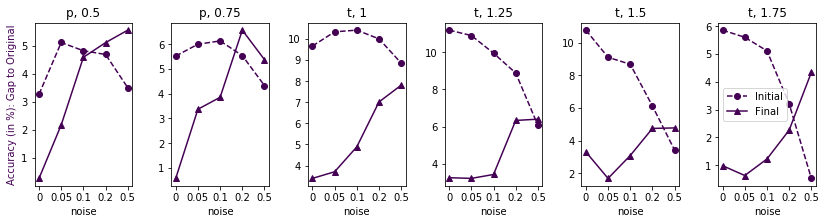

In [8]:
plot_results_noise(res_noise)